In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
import catboost
import catboost.datasets
import xgboost as xgb
import lightgbm as lgb
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
import time
warnings.filterwarnings('ignore')

In [160]:
## parameter setting for graphs
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (23, 15),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

In [198]:
dat = pd.read_csv("10100084.csv")

# Exploratory Data Analysis

## Data Cleaning

In [199]:
dat

,REF_DATE,GEO,DGUID,Currency outside banks and chartered bank deposits,Adjustments,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1968-01-03,Canada,NaN,Inter-bank demand deposits,Adjusted for discontinuities mainly related to...,Dollars,81,millions,6,v37223,1.12.2,0,NaN,NaN,NaN,0
1,1968-01-03,Canada,NaN,Inter-bank demand and notice deposits,Adjusted for discontinuities mainly related to...,Dollars,81,millions,6,v37224,1.13.2,0,NaN,NaN,NaN,0
2,1968-01-03,Canada,NaN,"Inter-bank demand, notice and term deposits",Adjusted for discontinuities mainly related to...,Dollars,81,millions,6,v37225,1.14.2,77,NaN,NaN,NaN,0
3,1968-01-10,Canada,NaN,Inter-bank demand deposits,Adjusted for discontinuities mainly related to...,Dollars,81,millions,6,v37223,1.12.2,0,NaN,NaN,NaN,0
4,1968-01-10,Canada,NaN,Inter-bank demand and notice deposits,Adjusted for discontinuities mainly related to...,Dollars,81,millions,6,v37224,1.13.2,0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20226,1993-10-27,Canada,NaN,Inter-bank demand deposits and other adjustmen...,Unadjusted,Dollars,81,millions,6,v37226,1.15.1,-2825,NaN,NaN,NaN,0
20227,1993-10-27,Canada,NaN,Inter-bank notice deposits and other adjustmen...,Unadjusted,Dollars,81,millions,6,v37227,1.16.1,-537,NaN,NaN,NaN,0
20228,1993-10-27,Canada,NaN,Inter-bank term deposits and other adjustments...,Unadjusted,Dollars,81,millions,6,v37228,1.17.1,-4470,NaN,NaN,NaN,0
20229,1993-10-27,Canada,NaN,Tax sheltered deposits at chartered banks,Unadjusted,Dollars,81,millions,6,v37229,1.18.1,65845,NaN,NaN,NaN,0


In [200]:
dat.isnull().sum()

REF_DATE                                                  0
GEO                                                       0
DGUID                                                 20231
Currency outside banks and chartered bank deposits        0
Adjustments                                               0
UOM                                                       0
UOM_ID                                                    0
SCALAR_FACTOR                                             0
SCALAR_ID                                                 0
VECTOR                                                    0
COORDINATE                                                0
VALUE                                                     0
STATUS                                                20231
SYMBOL                                                20231
TERMINATED                                            20231
DECIMALS                                                  0
dtype: int64

In [201]:
dat.dropna(axis=1,inplace=True)

In [202]:
dat.dtypes

REF_DATE                                              object
GEO                                                   object
Currency outside banks and chartered bank deposits    object
Adjustments                                           object
UOM                                                   object
UOM_ID                                                 int64
SCALAR_FACTOR                                         object
SCALAR_ID                                              int64
VECTOR                                                object
COORDINATE                                            object
VALUE                                                  int64
DECIMALS                                               int64
dtype: object

In [203]:
dat.describe()

,UOM_ID,SCALAR_ID,VALUE,DECIMALS
count,20231.0,20231.0,20231.000000,20231.0
mean,81.0,6.0,58770.888686,0.0
std,0.0,0.0,88810.377955,0.0
min,81.0,6.0,-6599.000000,0.0
25%,81.0,6.0,1022.000000,0.0
50%,81.0,6.0,20421.000000,0.0
75%,81.0,6.0,81488.000000,0.0
max,81.0,6.0,409332.000000,0.0


In [204]:
## categorical and continuous variables split
dat_cat = dat.loc[:,dat.dtypes=="object"]
dat_int = dat.loc[:,dat.dtypes=="int64"]

## Categorical Data Analysis

In [205]:
## convert REF_DATE to datetime format
dat_cat["REF_DATE"] = pd.to_datetime(dat_cat["REF_DATE"])

In [206]:
## access the range of REF_DATE in days
pd.date_range(dat_cat.loc[0,"REF_DATE"],dat_cat.loc[20230,"REF_DATE"],freq ="D")

DatetimeIndex(['1968-01-03', '1968-01-04', '1968-01-05', '1968-01-06',
               '1968-01-07', '1968-01-08', '1968-01-09', '1968-01-10',
               '1968-01-11', '1968-01-12',
               ...
               '1993-10-18', '1993-10-19', '1993-10-20', '1993-10-21',
               '1993-10-22', '1993-10-23', '1993-10-24', '1993-10-25',
               '1993-10-26', '1993-10-27'],
              dtype='datetime64[ns]', length=9430, freq='D')

In [207]:
## access the categorical levels of each catgeorical vairbale
dat_cat.apply(lambda x:len(np.unique(x)))

REF_DATE                                              1348
GEO                                                      1
Currency outside banks and chartered bank deposits      19
Adjustments                                              2
UOM                                                      1
SCALAR_FACTOR                                            1
VECTOR                                                  28
COORDINATE                                              28
dtype: int64

The variables *GEO*,*UOM*,*SCALAR_FACTOR* are useless because they just have one categorical level

In [208]:
## Drop the variables that have just 1 categorical level because they are not informative 
dat_cat.drop(["GEO","UOM","SCALAR_FACTOR"],axis=1,inplace=True)

In [209]:
## Summary the occurances of each categorical level of Currency outside banks and chartered bank deposits
dat_cat["Currency outside banks and chartered bank deposits"].value_counts()

Inter-bank demand deposits                                                                        1348
Inter-bank demand, notice and term deposits                                                       1348
Inter-bank demand and notice deposits                                                             1348
Currency and deposits, total                                                                      1234
Currency and total chartered bank deposits held by the general public, M3                         1234
Currency and all chequable deposits, M1B                                                          1234
Currency and all chequable notice and personal term deposits, M2                                  1234
Currency and demand deposits, M1                                                                  1234
Currency and privately held deposits                                                              1234
Currency outside banks, coin                                             

In [210]:
## summary Summary the occurances of each categorical level of VECTOR
dat_cat["VECTOR"].value_counts()

v37231    930
v37228    930
v37189    930
v37233    930
v37185    930
v37227    930
v37226    930
v37183    930
v37190    930
v37186    930
v37230    930
v37187    930
v37184    930
v37188    930
v37232    930
v37223    679
v37225    679
v37224    679
v37220    669
v37222    669
v37221    669
v37229    413
v37260    304
v37234    304
v37181    304
v37182    304
v37249    304
v37261    304
Name: VECTOR, dtype: int64

In [211]:
## summary Summary the occurances of each categorical level of COORDINATE
dat_cat["COORDINATE"].value_counts()

1.16.1    930
1.1.1     930
1.6.2     930
1.8.2     930
1.15.1    930
1.19.1    930
1.11.1    930
1.5.2     930
1.9.2     930
1.3.1     930
1.2.1     930
1.17.1    930
1.10.1    930
1.7.2     930
1.4.2     930
1.12.2    679
1.14.2    679
1.13.2    679
1.12.1    669
1.14.1    669
1.13.1    669
1.18.1    413
1.7.1     304
1.6.1     304
1.9.1     304
1.5.1     304
1.8.1     304
1.4.1     304
Name: COORDINATE, dtype: int64

In [212]:
## Access the unique number of levels of each categorical variable
dat_cat.apply(lambda x:len(np.unique(x)))

REF_DATE                                              1348
Currency outside banks and chartered bank deposits      19
Adjustments                                              2
VECTOR                                                  28
COORDINATE                                              28
dtype: int64

In [213]:
dat_cat.tail(36)

,REF_DATE,Currency outside banks and chartered bank deposits,Adjustments,VECTOR,COORDINATE
20195,1993-10-20,"Currency outside banks, coin",Unadjusted,v37232,1.3.1
20196,1993-10-20,Currency and privately held deposits,Adjusted for discontinuities mainly related to...,v37185,1.4.2
20197,1993-10-20,Currency and total chartered bank deposits hel...,Adjusted for discontinuities mainly related to...,v37186,1.5.2
20198,1993-10-20,Currency and all chequable notice and personal...,Adjusted for discontinuities mainly related to...,v37187,1.6.2
20199,1993-10-20,"Currency and all chequable deposits, M1B",Adjusted for discontinuities mainly related to...,v37188,1.7.2
20200,1993-10-20,"Currency and demand deposits, M1",Adjusted for discontinuities mainly related to...,v37189,1.8.2
20201,1993-10-20,"Currency and deposits, total",Adjusted for discontinuities mainly related to...,v37190,1.9.2
20202,1993-10-20,"Demand, less private sector float",Unadjusted,v37183,1.10.1
20203,1993-10-20,M1 + daily interest chequing accounts + non-pe...,Unadjusted,v37184,1.11.1
20204,1993-10-20,Inter-bank demand deposits,Unadjusted,v37220,1.12.1


The chi square test test result shows that **Vector** is independent of **COORDINATE**,so we can exlcude one of them from the dataset.Let's remove **VECTOR**.

### Test result of the independence between **VECTOR** and **COORDINATE**

In [214]:
import researchpy as rp
crosstab, test_results_1, expected = rp.crosstab(dat_cat["VECTOR"], dat_cat["COORDINATE"],
                                               test= "chi-square",
                                              expected_freqs= True,
                                               prop= "cell")
test_results_1

,Chi-square test,results
0,Pearson Chi-square ( 729.0) =,546237.0
1,p-value =,0.0
2,Cramer's V =,1.0


### Test result of the independence between **Adjustments** and **COORDINATE**

In [215]:
crosstab, test_results_2, expected = rp.crosstab(dat_cat["Adjustments"], dat_cat["COORDINATE"],
                                               test= "chi-square",
                                              expected_freqs= True,
                                               prop= "cell")
crosstab

COORDINATE                \
COORDINATE                                              1.1.1 1.10.1 1.11.1   
Adjustments                                                                   
Adjusted for discontinuities mainly related to ...        0.0    0.0    0.0   
Unadjusted                                                4.6    4.6    4.6   
All                                                       4.6    4.6    4.6   

                                                                         \
COORDINATE                                         1.12.1 1.12.2 1.13.1   
Adjustments                                                               
Adjusted for discontinuities mainly related to ...   0.00   3.36   0.00   
Unadjusted                                           3.31   0.00   3.31   
All                                                  3.31   3.36   3.31   

                                                                         \
COORDINATE                                         1.13.2 1.14.1 1.14.2   
Adjustments                                                               
Adjusted for discontinuities mainly related to ...   3.36   0.00   3.36   
Unadjusted                                           0.00   3.31   0.00   
All                                                  3.36   3.31   3.36   

                                                           ...              \
COORDINATE                                         1.15.1  ... 1.5.2 1.6.1   
Adjustments                                                ...               
Adjusted for discontinuities mainly related to ...    0.0  ...   4.6   0.0   
Unadjusted                                            4.6  ...   0.0   1.5   
All                                                   4.6  ...   4.6   1.5   

                                                                            \
COORDINATE                                         1.6.2 1.7.1 1.7.2 1.8.1   
Adjustments                                                                  
Adjusted for discontinuities mainly related to ...   4.6   0.0   4.6   0.0   
Unadjusted                                           0.0   1.5   0.0   1.5   
All                                                  4.6   1.5   4.6   1.5   

                                                                              
COORDINATE                                         1.8.2 1.9.1 1.9.2     All  
Adjustments                                                                   
Adjusted for discontinuities mainly related to ...   4.6   0.0   4.6   37.65  
Unadjusted                                           0.0   1.5   0.0   62.35  
All                                                  4.6   1.5   4.6  100.00  

[3 rows x 29 columns]

### Test result of the independence between **Currency outside banks and chartered bank deposits** and **COORDINATE**

In [216]:
crosstab, test_results_3, expected = rp.crosstab(dat_cat["Currency outside banks and chartered bank deposits"], dat_cat["COORDINATE"],
                                               test= "chi-square",
                                              expected_freqs= True,
                                               prop= "cell")
test_results_3

,Chi-square test,results
0,Pearson Chi-square ( 486.0) =,364158.0
1,p-value =,0.0
2,Cramer's V =,1.0


In [217]:
dat_cat

,REF_DATE,Currency outside banks and chartered bank deposits,Adjustments,VECTOR,COORDINATE
0,1968-01-03,Inter-bank demand deposits,Adjusted for discontinuities mainly related to...,v37223,1.12.2
1,1968-01-03,Inter-bank demand and notice deposits,Adjusted for discontinuities mainly related to...,v37224,1.13.2
2,1968-01-03,"Inter-bank demand, notice and term deposits",Adjusted for discontinuities mainly related to...,v37225,1.14.2
3,1968-01-10,Inter-bank demand deposits,Adjusted for discontinuities mainly related to...,v37223,1.12.2
4,1968-01-10,Inter-bank demand and notice deposits,Adjusted for discontinuities mainly related to...,v37224,1.13.2
...,...,...,...,...,...
20226,1993-10-27,Inter-bank demand deposits and other adjustmen...,Unadjusted,v37226,1.15.1
20227,1993-10-27,Inter-bank notice deposits and other adjustmen...,Unadjusted,v37227,1.16.1
20228,1993-10-27,Inter-bank term deposits and other adjustments...,Unadjusted,v37228,1.17.1
20229,1993-10-27,Tax sheltered deposits at chartered banks,Unadjusted,v37229,1.18.1


Our tentative approach is to exlcude **VECTOR**,**Currency outside banks and chartered bank deposits**,**Adjustments** from the dataset because they are all highly correlated with **COORDINATE**, which suggests that they are redundant.

In [218]:
dat_cat.drop(["VECTOR"],axis=1,inplace=True)

dat_cat

## Continuous Data Analysis

In [219]:
## Access the unique number of levels of each continuous vairable
dat_int.apply(lambda x:len(np.unique(x)))

UOM_ID           1
SCALAR_ID        1
VALUE        15029
DECIMALS         1
dtype: int64

Variables **UOM_ID**,**SCALAR_ID**,and **DECIMALS** have just one value so they are not informative and therefored deleted.

In [220]:
dat_int.drop(["UOM_ID","SCALAR_ID","DECIMALS"],axis=1,inplace=True)

# Model Buildling

In [221]:
dat = pd.concat([dat_cat,dat_int],axis=1) 

In [222]:
dat

,REF_DATE,Currency outside banks and chartered bank deposits,Adjustments,COORDINATE,VALUE
0,1968-01-03,Inter-bank demand deposits,Adjusted for discontinuities mainly related to...,1.12.2,0
1,1968-01-03,Inter-bank demand and notice deposits,Adjusted for discontinuities mainly related to...,1.13.2,0
2,1968-01-03,"Inter-bank demand, notice and term deposits",Adjusted for discontinuities mainly related to...,1.14.2,77
3,1968-01-10,Inter-bank demand deposits,Adjusted for discontinuities mainly related to...,1.12.2,0
4,1968-01-10,Inter-bank demand and notice deposits,Adjusted for discontinuities mainly related to...,1.13.2,0
...,...,...,...,...,...
20226,1993-10-27,Inter-bank demand deposits and other adjustmen...,Unadjusted,1.15.1,-2825
20227,1993-10-27,Inter-bank notice deposits and other adjustmen...,Unadjusted,1.16.1,-537
20228,1993-10-27,Inter-bank term deposits and other adjustments...,Unadjusted,1.17.1,-4470
20229,1993-10-27,Tax sheltered deposits at chartered banks,Unadjusted,1.18.1,65845


In [223]:
unique_co = np.unique(dat["COORDINATE"])

In [224]:
dat.set_index("REF_DATE",inplace=True)

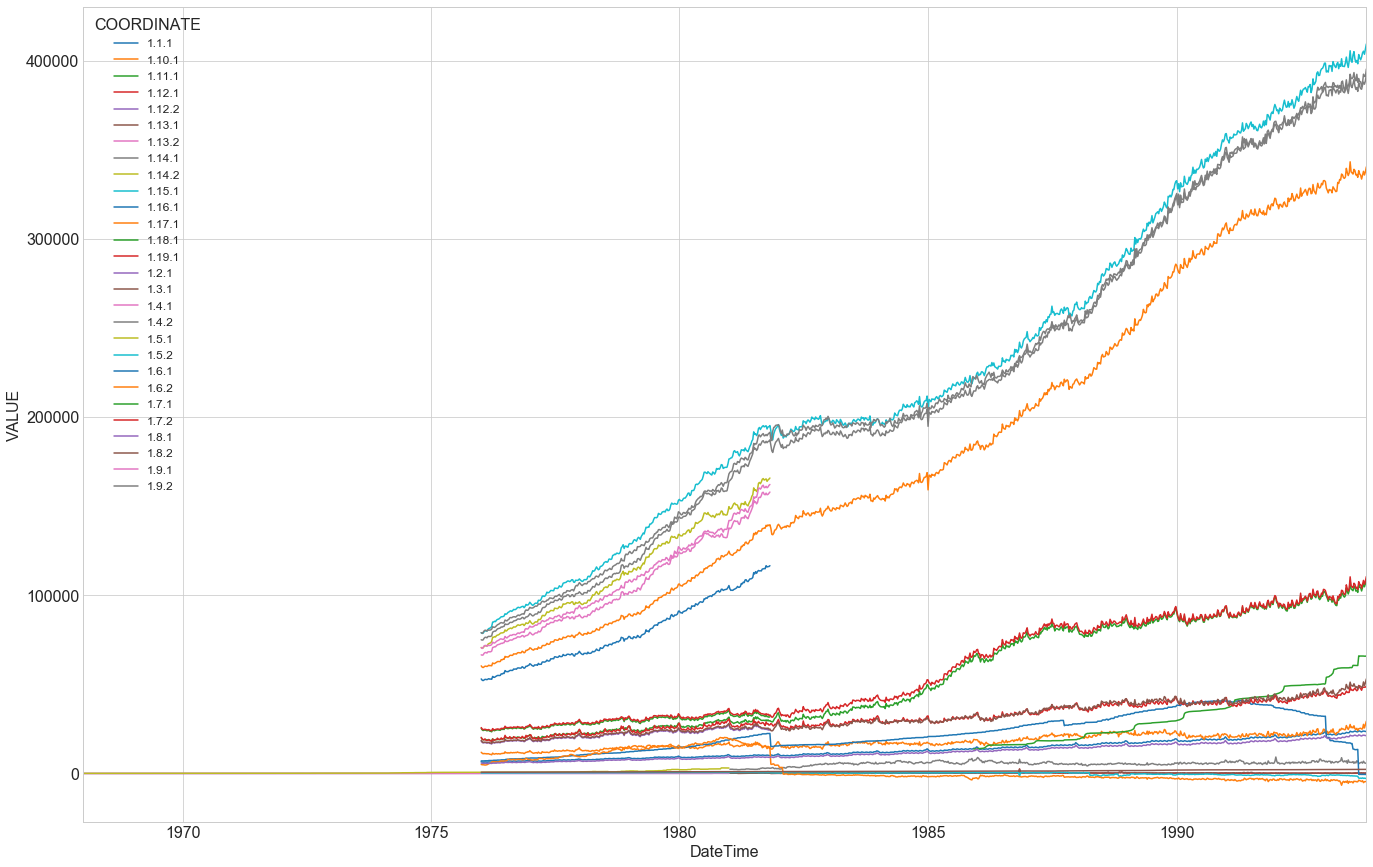

In [271]:
ax = dat.pivot(columns="COORDINATE", values="VALUE").plot()
ax.set_xlabel("DateTime")
ax.set_ylabel("VALUE")
leg = ax.legend(fontsize = 'large')
leg.set_title("COORDINATE", prop = {'size':16})
plt.show()

In [226]:
dat.index

DatetimeIndex(['1968-01-03', '1968-01-03', '1968-01-03', '1968-01-10',
               '1968-01-10', '1968-01-10', '1968-01-17', '1968-01-17',
               '1968-01-17', '1968-01-24',
               ...
               '1993-10-27', '1993-10-27', '1993-10-27', '1993-10-27',
               '1993-10-27', '1993-10-27', '1993-10-27', '1993-10-27',
               '1993-10-27', '1993-10-27'],
              dtype='datetime64[ns]', name='REF_DATE', length=20231, freq=None)

In [227]:
# format your data to desired format. Here I chose YYYY-MM-DD but you can set it to whatever you want.
#import matplotlib.dates as mdates
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# rotate and align the tick labels so they look better
#fig.autofmt_xdate()
#np.unique(dat.index)[::200]
dat.index = pd.to_datetime(dat.index)
dat.index

DatetimeIndex(['1968-01-03', '1968-01-03', '1968-01-03', '1968-01-10',
               '1968-01-10', '1968-01-10', '1968-01-17', '1968-01-17',
               '1968-01-17', '1968-01-24',
               ...
               '1993-10-27', '1993-10-27', '1993-10-27', '1993-10-27',
               '1993-10-27', '1993-10-27', '1993-10-27', '1993-10-27',
               '1993-10-27', '1993-10-27'],
              dtype='datetime64[ns]', name='REF_DATE', length=20231, freq=None)

(array([-100000.,       0.,  100000.,  200000.,  300000.,  400000.,
         500000.]),
 <a list of 7 Text yticklabel objects>)

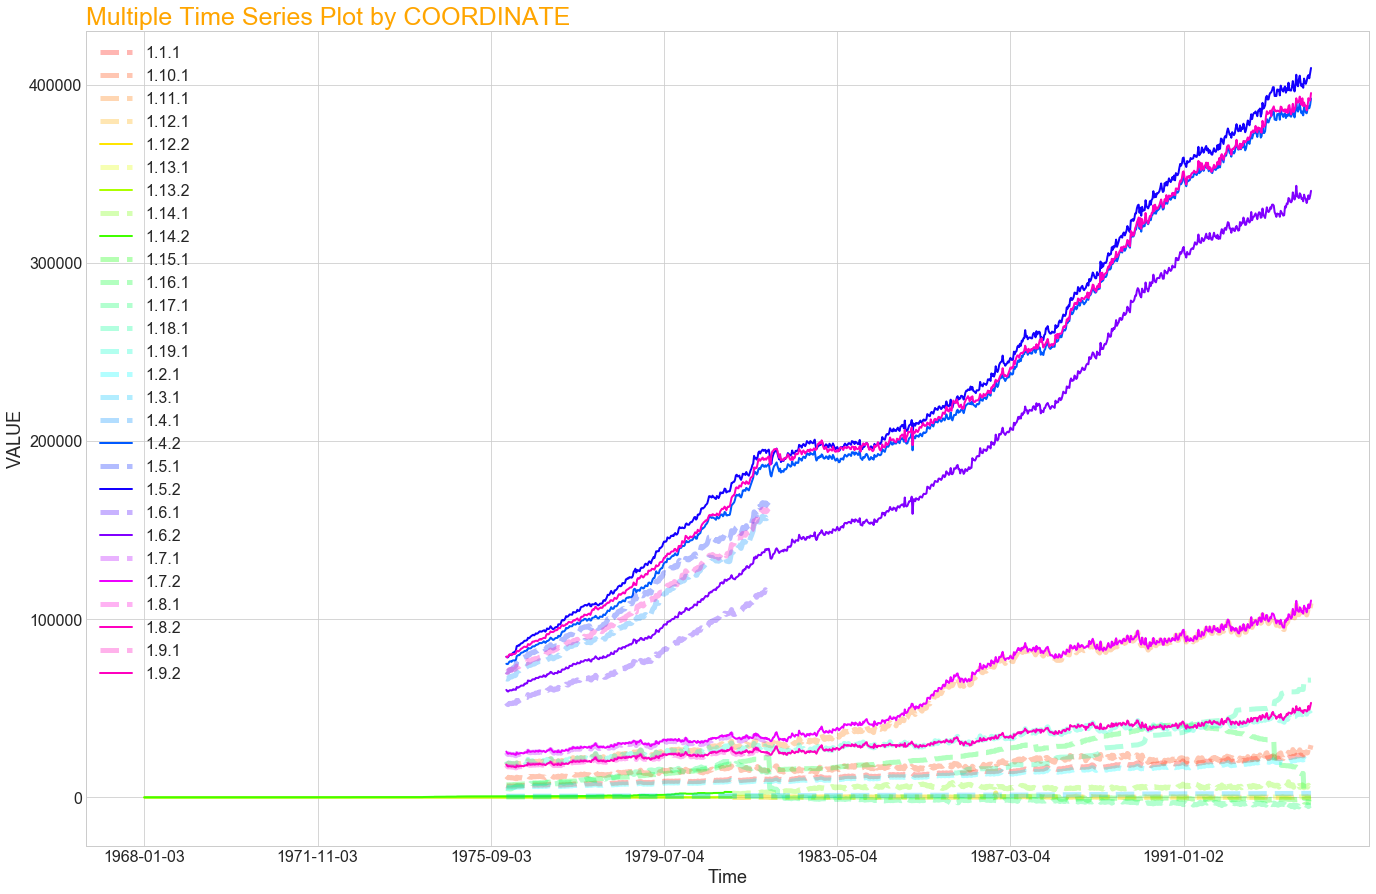

In [228]:
# style
fig = plt.subplots()
 
# create a color palette
palette = plt.get_cmap('gist_rainbow')
 
# multiple line plot
num = 0
for level in np.unique(dat["COORDINATE"]):
    num+=10
    sub_dat = dat.loc[dat["COORDINATE"]== level,:]
    if sub_dat.iloc[1,1] == "Unadjusted":
        plt.plot(sub_dat["VALUE"], color=palette(num),linestyle="--",linewidth=5, alpha=0.3,label = level)
    else:
        plt.plot(sub_dat["VALUE"], color=palette(num),linestyle="-",linewidth=2, alpha=1,label = level)

# Add legend
plt.legend()
 
# Add titles
plt.title("Multiple Time Series Plot by COORDINATE", loc='left', fontsize=25, fontweight=0, color='orange')


plt.xlabel("Time", fontsize=18)
plt.ylabel("VALUE", fontsize=18)
plt.xticks(np.unique(dat.index)[::200], fontsize=16, horizontalalignment='center')
plt.yticks(fontsize = 16)

In [232]:
ad_level = dat["Adjustments"].unique()
ad_level[0]

'Adjusted for discontinuities mainly related to the 1980 Bank Act revision'

In [233]:
dat_ad = dat.loc[dat["Adjustments"]==ad_level[0],:]
dat_unad = dat.loc[dat["Adjustments"]==ad_level[1],:]

In [234]:
curr_value_ad = dat_ad[["Currency outside banks and chartered bank deposits","VALUE"]].groupby("Currency outside banks and chartered bank deposits").sum()
curr_value_unad = dat_unad[["Currency outside banks and chartered bank deposits","VALUE"]].groupby("Currency outside banks and chartered bank deposits").sum()

In [247]:
curr_value_total = dat[["Currency outside banks and chartered bank deposits","VALUE","Adjustments"]].groupby(["Currency outside banks and chartered bank deposits","Adjustments"],as_index=False).sum()

In [266]:
curr_value_total

,Currency outside banks and chartered bank deposits,Adjustments,VALUE
0,"Currency and all chequable deposits, M1B",Adjusted for discontinuities mainly related to...,54496817
1,"Currency and all chequable deposits, M1B",Unadjusted,8877687
2,Currency and all chequable notice and personal...,Adjusted for discontinuities mainly related to...,172473140
3,Currency and all chequable notice and personal...,Unadjusted,24143021
4,"Currency and demand deposits, M1",Adjusted for discontinuities mainly related to...,29172278
5,"Currency and demand deposits, M1",Unadjusted,6602691
6,"Currency and deposits, total",Adjusted for discontinuities mainly related to...,208700299
7,"Currency and deposits, total",Unadjusted,33273185
8,Currency and privately held deposits,Adjusted for discontinuities mainly related to...,205865450
9,Currency and privately held deposits,Unadjusted,32197824


In [251]:
# include Adjustments
curr_value_total_1 = curr_value_total.set_index("Currency outside banks and chartered bank deposits")

In [270]:
curr_value_total_2.loc[curr_value_total_2["Adjustments"]==ad_level[0],"VALUE"]

Currency outside banks and chartered bank deposits
Currency and total chartered bank deposits held by the general public, M3    214119620
Currency and deposits, total                                                 208700299
Currency and privately held deposits                                         205865450
Currency and all chequable notice and personal term deposits, M2             172473140
Currency and all chequable deposits, M1B                                      54496817
Currency and demand deposits, M1                                              29172278
Inter-bank demand, notice and term deposits                                     437104
Inter-bank demand and notice deposits                                             9917
Inter-bank demand deposits                                                        9917
Name: VALUE, dtype: int64

## Adjusted

<Figure size 2736x2736 with 0 Axes>

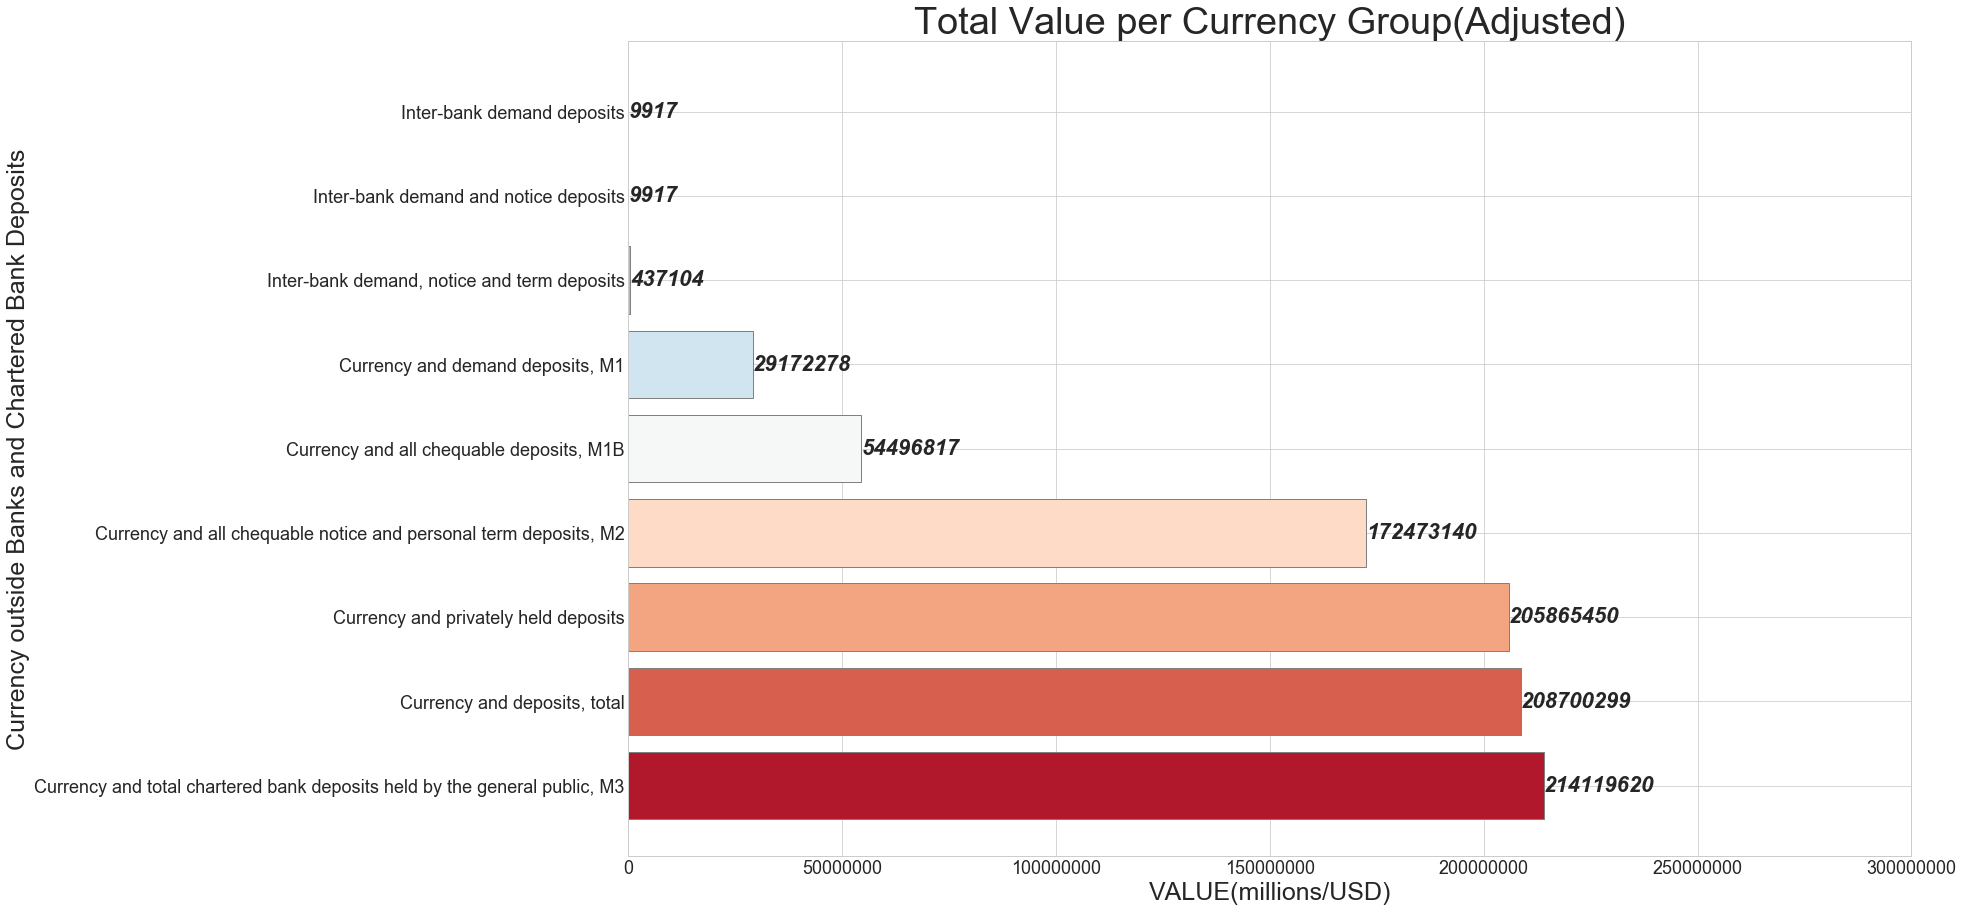

In [269]:
curr_value_1 =curr_value_ad.sort_values(by=['VALUE'],ascending=False)

plt.figure(figsize=(38, 38))
fig, ax = plt.subplots()
n = curr_value_1.index
s = curr_value_1["VALUE"]

bar = ax.barh(curr_value_1.index,curr_value_1["VALUE"],color=sns.color_palette("RdBu", len(s)), edgecolor='gray')

ax.ticklabel_format(style='plain',axis='x')
plt.xlim((0, 300000000))
plt.xlabel("VALUE(millions/USD)", fontsize=25)
plt.ylabel("Currency outside Banks and Chartered Bank Deposits", fontsize=25)
plt.title("Total Value per Currency Group(Adjusted)",fontsize = 38)
plt.xticks(fontsize=18, horizontalalignment='center')
plt.yticks(fontsize = 18)

xlocs, xlabs = plt.xticks()
ylocs, ylabs = plt.yticks()

for i, v in enumerate(s.values):
    plt.text(v, i ,str(v),verticalalignment='center',fontdict={'fontweight':'bold', 'size':22,"fontstyle":'oblique'})


In [ ]:
## Unadjusted

<Figure size 2736x2736 with 0 Axes>

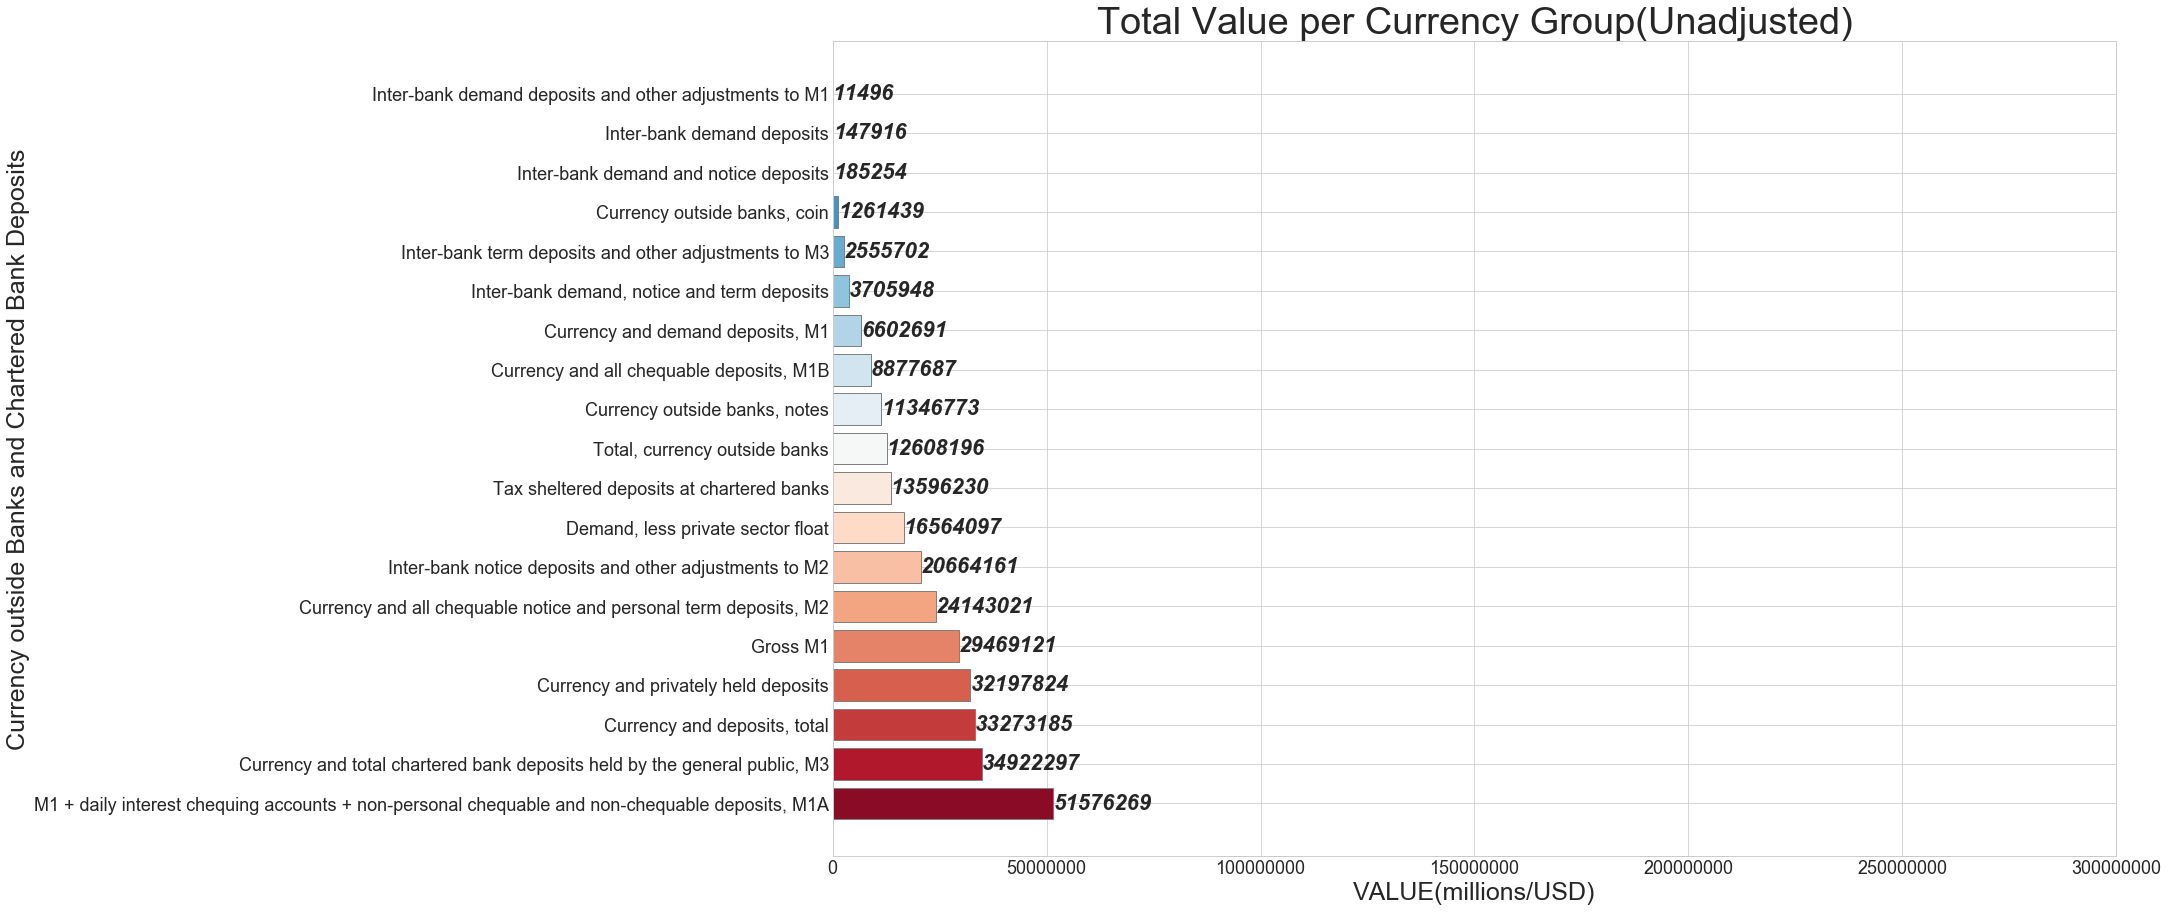

In [268]:
curr_value_2 =curr_value_unad.sort_values(by=['VALUE'],ascending=False)

plt.figure(figsize=(38, 38))
fig, ax = plt.subplots()
n = curr_value_2.index
s = curr_value_2["VALUE"]

bar = ax.barh(curr_value_2.index,curr_value_2["VALUE"],color=sns.color_palette("RdBu", len(s)), edgecolor='gray')

ax.ticklabel_format(style='plain',axis='x')
plt.xlim((0, 300000000))
plt.xlabel("VALUE(millions/USD)", fontsize=25)
plt.ylabel("Currency outside Banks and Chartered Bank Deposits", fontsize=25)
plt.title("Total Value per Currency Group(Unadjusted)",fontsize = 38)
plt.xticks(fontsize=18, horizontalalignment='center')
plt.yticks(fontsize = 18)

xlocs, xlabs = plt.xticks()
ylocs, ylabs = plt.yticks()

for i, v in enumerate(s.values):
    plt.text(v, i ,str(v),verticalalignment='center',fontdict={'fontweight':'bold', 'size':22,"fontstyle":'oblique'})
